this script is for visualizing the results from the case study

In [28]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [29]:
from src.game_theory_helpers import powerset, is_convex_game, get_loo, get_shapley_value, get_nash_bargaining_solution, get_banzhaf_value, core_nonempty, game_is_superadditive
from src.nucleolus import get_nucleolus
from src.least_core_nucleolus import get_least_core_nucleolus

In [30]:
def make_game_superadditive(v: dict, players: list) -> dict:
    """
    make game superadditive by adjusting values of coalitions

    v: Characteristic function of the game, must be defined for EVERY coalition
        {frozenset -> float}
    players: list of players
    """
    v_superadd = v.copy()
    for S in powerset(players, exclude_empty=True):
        T = frozenset(players) - S
        union = S.union(T)
        if v_superadd[union] < v_superadd[S] + v_superadd[T]:
            v_superadd[union] = v_superadd[S] + v_superadd[T]
    return v_superadd

In [31]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")

# Extract the first 4 colors
base_colors = [cmap(i) for i in range(10)]

# Create extended cycle: first full alpha, then alpha=0.5
colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]

# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

C:\Users\pasca\AppData\Local\Temp\ipykernel_9208\536717058.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


In [32]:
# services = ['FFR-FCR']  # list of services to visualize
services = ['FFR + FCR-D']  # list of services to visualize
dvpps_infos = {}  # dictionary to hold dvpp info dataframes
# main_paths = ['pics/v_case_0604/', 'pics/v_case_0704/', 'pics/v_case/']
# main_path = 'pics/v_case_combined/'
# main_path = 'pics/v_meteoblue/'
# main_path = 'pics/v_paper/'
main_path = 'pics/v_update_050126/'
df_expected = pd.DataFrame()
df_realized = pd.DataFrame()
dvpp_info = pd.DataFrame()
df_bids = pd.DataFrame()

df_expected = pd.read_csv(f'{main_path}expected_values_DPF.csv', index_col=[0,1], header=[0,1,2])
df_expected.columns = [tuple(c for c in col if c!='nan') for col in df_expected.columns.values]
df_realized = pd.read_csv(f'{main_path}values_DPF.csv', index_col=[0,1], header=[0,1,2])
df_realized.columns = [tuple(c for c in col if c!='nan') for col in df_realized.columns.values]
for service in services:
    dvpps_infos[service] = pd.read_csv(f'{main_path}dvpp_info_DPF_{service}.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')

## option to merge folders

In [33]:
# # quicklt merge the files in v_case
# for main_path in main_paths:
#     df_expected_tmp = pd.read_csv(f'{main_path}expected_values_DPF.csv', index_col=[0,1], header=[0,1,2])
#     # df_expected_tmp.columns = [tuple(c for c in col if c!='nan') for col in df_expected_tmp.columns.values]
#     df_realized_tmp = pd.read_csv(f'{main_path}values_DPF.csv', index_col=[0,1], header=[0,1,2])
#     # df_realized_tmp.columns = [tuple(c for c in col if c!='nan') for col in df_realized_tmp.columns.values]
#     df_expected = pd.concat([df_expected, df_expected_tmp])
#     df_realized = pd.concat([df_realized, df_realized_tmp])
#     # also do for dvpp_info_DPF_FFR-FCR
#     dvpp_info_tmp = pd.read_csv(f'{main_path}dvpp_info_DPF_FFR-FCR.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')
#     dvpp_info = pd.concat([dvpp_info, dvpp_info_tmp])
#     # also for bids
#     # df_bids = pd.read_csv(f'{main_path}/bids_DPF_{service}.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')
#     df_bids_tmp = pd.read_csv(f'{main_path}bids_DPF_FFR-FCR.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')
#     df_bids = pd.concat([df_bids, df_bids_tmp])

In [34]:
# # change index for df_expected
# new_index = pd.MultiIndex.from_product((['FFR-FCR'], np.arange(len(df_expected))))
# df_expected.index = new_index
# df_realized.index = new_index

In [35]:
# # save in folder
# main_path = 'pics/v_case_combined/'
# df_expected.to_csv(f'{main_path}expected_values_DPF.csv')
# df_realized.to_csv(f'{main_path}values_DPF.csv')
# dvpp_info.to_csv(f'{main_path}dvpp_info_DPF_FFR-FCR.csv')
# df_bids.to_csv(f'{main_path}bids_DPF_FFR-FCR.csv')

## Pure-Nucleolus Reward Split

In [36]:
# get reward split of devices
players = [c[0] for c in df_expected.columns if len(c)==1]
idxes = pd.MultiIndex.from_product((df_expected.index.get_level_values(1), ['E-Value', 'E-Nucleolus', 'R-Value', 'R-Nucleolus']))
df_reward_split = pd.DataFrame(0.0, index=idxes, columns=players)
superadditivity_counter = 0
convexity_counter = 0
core_non_empty_counter = 0
for idx, row in df_expected.iterrows():
    # 1. Expected game convert to dictionary
    v = {frozenset(k): val for k, val in row.items()}
    v[frozenset()] = 0.0  # ensure empty set has value 0
    # v = make_game_superadditive(v, players)  # ensure superadditivity
    if game_is_superadditive(v, players):
        superadditivity_counter += 1
        nucleolus = get_nucleolus(v, players)
    else:
        print(f"for time {idx[0]}, expected game is not superadditive.")
        print(v)
        nucleolus = get_least_core_nucleolus(v, players)
    if is_convex_game(v, players):
        convexity_counter += 1
    if core_nonempty(v, players):
        core_non_empty_counter += 1
    df_reward_split.loc[(idx[1], 'E-Nucleolus'), list(k for k in nucleolus.keys())] = list(nucleolus.values())
    df_reward_split.loc[(idx[1], 'E-Value'), list(p for p in players)] = [v[frozenset({p})] for p in players]
    # 2. Realized game convert to dictionary
    v_realized = {frozenset(k): val for k, val in df_realized.loc[idx].items()}
    v_realized[frozenset()] = 0.0  # ensure empty set
    nucleolus_realized = get_least_core_nucleolus(v_realized, players)
    df_reward_split.loc[(idx[1], 'R-Nucleolus'), list(k for k in nucleolus_realized.keys())] = list(nucleolus_realized.values())
    df_reward_split.loc[(idx[1], 'R-Value'), list(p for p in players)] = [v_realized[frozenset({p})] for p in players]

for time FFR + FCR-D, expected game is not superadditive.
{frozenset({'PV'}): 0.0, frozenset({'Wind'}): 0.0, frozenset({'BESS'}): 2.0, frozenset({'PV', 'Wind'}): 0.0, frozenset({'PV', 'BESS'}): 0.0, frozenset({'BESS', 'Wind'}): 0.0, frozenset({'PV', 'BESS', 'Wind'}): 0.0, frozenset(): 0.0}
for time FFR + FCR-D, expected game is not superadditive.
{frozenset({'PV'}): 0.0, frozenset({'Wind'}): 0.0, frozenset({'BESS'}): 1.875, frozenset({'PV', 'Wind'}): 0.0, frozenset({'PV', 'BESS'}): 0.0, frozenset({'BESS', 'Wind'}): 0.0, frozenset({'PV', 'BESS', 'Wind'}): 0.0, frozenset(): 0.0}
for time FFR + FCR-D, expected game is not superadditive.
{frozenset({'PV'}): 0.0, frozenset({'Wind'}): 0.0, frozenset({'BESS'}): 1.25, frozenset({'PV', 'Wind'}): 0.0, frozenset({'PV', 'BESS'}): 0.0, frozenset({'BESS', 'Wind'}): 0.0, frozenset({'PV', 'BESS', 'Wind'}): 0.04349, frozenset(): 0.0}
for time FFR + FCR-D, expected game is not superadditive.
{frozenset({'PV'}): 1.10834, frozenset({'Wind'}): 0.0, frozens

In [37]:
print(f"For {main_path}, out of {len(df_expected)} games, {superadditivity_counter} superadditive, {convexity_counter} convex and {core_non_empty_counter} non-empty core.") 

For pics/v_update_050126/, out of 159 games, 4 superadditive, 0 convex and 88 non-empty core.


# Reward Split with New Method

In [38]:
from src.game_theory_helpers import evaluate_full_game, solve_optimal_partition

In [39]:
# PARAMS
MAKE_games_superadditive = True   # use superadditive formulation
GAME_types_to_plot = ['Shapley', 'Nucleolus', 'Sub-Game']  # ['Shapley', 'Nucleolus', 'Sub-Game']

In [40]:
df_rewards = evaluate_full_game(df_expected, df_realized, MAKE_games_superadditive=MAKE_games_superadditive)

In [41]:
hours = df_rewards.index.get_level_values(0).unique()
print(df_rewards.loc[(hours, 'Realized', 'Reward'), 'Method'].value_counts())
print(f"out of {len(hours)}.")

Method
Shapley      129
Nucleolus     30
Name: count, dtype: int64
out of 159.


In [42]:
# also show realized game
print(df_rewards.loc[(hours, 'Realized', 'Reward'), 'Method-Realized'].value_counts())
print(f"out of {len(hours)}.")

Method-Realized
Shapley      87
Sub-Game     44
Nucleolus    28
Name: count, dtype: int64
out of 159.


In [43]:
# new multiindex
idxs1 = df_rewards.index.get_level_values(0).unique().values
idxs2 = df_rewards.index.get_level_values(1).unique().values
idxs3 = df_rewards.index.get_level_values(2).unique().values
idxs2_new = []
for i in idxs2:
    # append idx3
    for j in idxs3:
        idxs2_new.append(f'{i}-{j}')

In [44]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors[1:])

In [45]:
df_rewards.index = pd.MultiIndex.from_product([idxs1, idxs2_new])

In [46]:
devices = ['PV', 'Wind', 'BESS']

In [47]:
df_plot = df_rewards[devices]
df_mean = df_plot.groupby(level=1).mean()
df_mean = df_mean.transpose()

In [48]:
plt.rcParams.update({'font.size': 15})

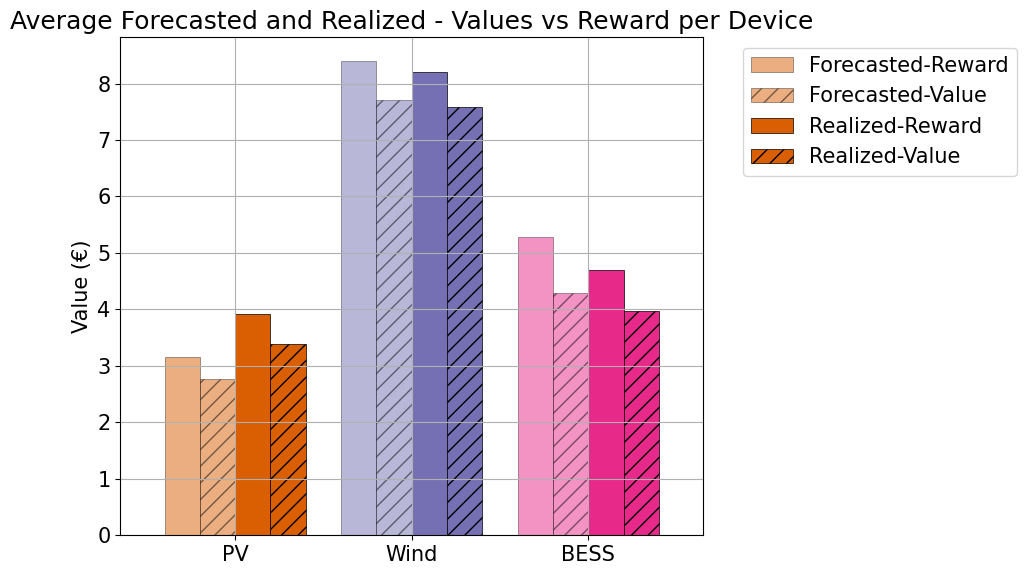

In [49]:
# 2. Define Colors
device_colors = {
    'PV': (217/255, 95/255, 2/255),
    'Wind': (117/255, 112/255, 179/255),
    'BESS': (231/255, 41/255, 138/255)
}

# 3. Create the Plot
fig, ax = plt.subplots(figsize=(10, 6))
df_mean.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', linewidth=0.5)

# 4. Apply Custom Styles
# ax.containers contains 4 groups of bars (one for each column in the dataframe)
# Order: Forecasted-Reward (0), Forecasted-Value (1), Realized-Reward (2), Realized-Value (3)

for col_idx, container in enumerate(ax.containers):
    # --- Determine Style per Column ---
    alpha = 1.0
    hatch = None
    
    # "bars 1 and 2 should be alpha=.5" -> indices 0 and 1
    if col_idx in [0, 1]:
        alpha = 0.5
        
    # "bars 2 and 4 should be hatch='//'" -> indices 1 and 3
    if col_idx in [1, 3]:
        hatch = '//'
        
    # --- Apply to each bar in the group ---
    # We zip with df_mean.index to know which device (PV/Wind/BESS) the bar belongs to
    for bar, label in zip(container, df_mean.index):
        # Set Color based on device (row index)
        color = device_colors.get(label)
        bar.set_facecolor(color)
        
        # Set Alpha
        bar.set_alpha(alpha)
        
        # Set Hatch
        bar.set_hatch(hatch)

# Final Formatting
ax.set_ylabel('Value (€)')
ax.set_title('Average Forecasted and Realized - Values vs Reward per Device')
plt.xticks(rotation=0) # Keep labels horizontal
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend out
plt.tight_layout()
plt.grid()

plt.savefig('custom_bar_plot.png')

In [50]:
import seaborn as sns

In [51]:
from scipy import stats
import numpy as np
import pandas as pd

def assess_distribution_fit(data, distributions_to_test):
    """
    Fits and compares distributions using the Maximum Likelihood Estimation 
    (MLE) for fitting and the Kolmogorov-Smirnov (KS) test for scoring.
    """
    results = []
    
    # 💡 The list of distributions you want to check
    # Other common choices: 'weibull_min', 'lognorm', 'gamma', 'beta'
    
    for dist_name in distributions_to_test:
        dist = getattr(stats, dist_name)
        
        try:
            # 1. Fit the parameters using Maximum Likelihood Estimation (MLE)
            params = dist.fit(data)
            
            # 2. Perform the KS test to compare the data to the fitted distribution
            # H0: The data comes from the specified distribution
            ks_stat, p_value = stats.kstest(data, dist_name, args=params)
            
            results.append({
                'Distribution': dist_name,
                'KS Statistic': ks_stat, # Lower is better
                'P-Value': p_value      # Higher (ideally > 0.05) is better
            })
        except Exception:
            # Catch distributions that might fail to converge on parameters
            results.append({'Distribution': dist_name, 'KS Statistic': np.nan, 'P-Value': np.nan})
            
    # Sort by the KS Statistic to find the best fit quickly
    df = pd.DataFrame(results).sort_values(by='KS Statistic', ascending=True)
    
    # 
    
    return df

# Example Usage (Use your actual data instead of this random sample)
data = np.random.normal(loc=5, scale=1.5, size=100)
test_dists = ['norm', 't', 'laplace', 'expon']

fit_results = assess_distribution_fit(data, test_dists)
print(fit_results)

  Distribution  KS Statistic       P-Value
0         norm      0.088439  3.918333e-01
1            t      0.088440  3.918180e-01
2      laplace      0.137530  4.119405e-02
3        expon      0.291031  5.367837e-08


For Forecasted-Reward, 1092.9 values above 20, 1585.2 values below or equal to 20.
For Forecasted-Reward, 34 counts above 20, 443 counts below or equal to 20.
7.13% of values make up 40.81% of the total reward.
For Realized-Reward, 1372.9 values above 20, 1548.3 values below or equal to 20.
For Realized-Reward, 39 counts above 20, 392 counts below or equal to 20.
9.05% of values make up 47.00% of the total reward.


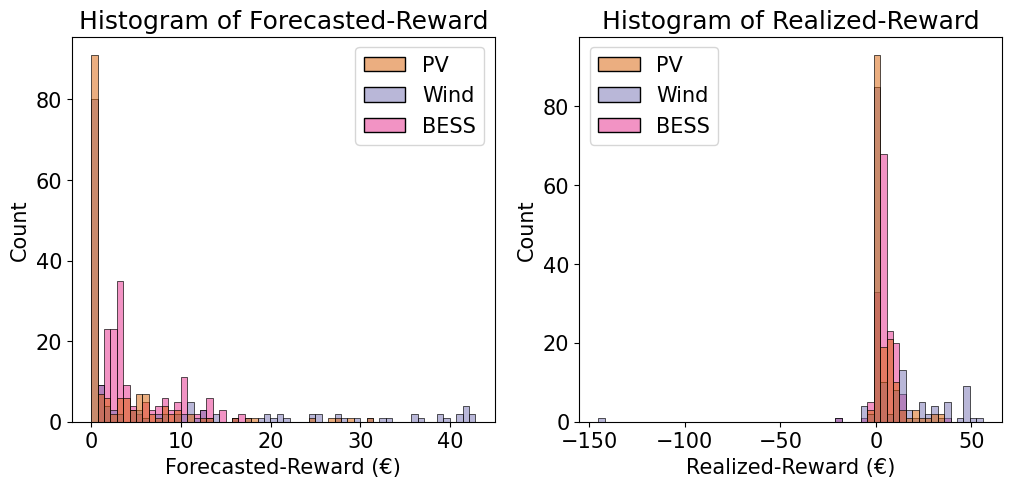

In [52]:
# only plot rewad, not values
df_plot_2 = df_rewards.loc(axis=0)[:, ['Forecasted-Reward', 'Realized-Reward']]

# make 4 subplots axis
fig, axs = plt.subplots(1,2, figsize=(12, 5))

for i, x in enumerate(df_plot_2.index.get_level_values(1).unique().values):
    sns.histplot(df_plot_2.loc(axis=0)[:, x], bins=60, ax=axs[i])
    axs[i].set_title(f'Histogram of {x}')
    axs[i].set_xlabel(f'{x} (€)')
    
    # fit_results = assess_distribution_fit([x for xs in df_plot.loc(axis=0)[:, x].values for x in xs], test_dists)
    # print(fit_results)
    # print the numer of values above
    vals = [xs for x in df_plot_2.loc(axis=0)[:, x].values for xs in x[:3]]
    thresh = 20
    above_thresh, above_count = sum(v for v in vals if v > thresh), sum(1 for v in vals if v > thresh)
    below_thresh, below_count = sum(v for v in vals if 0 <= v <= thresh), sum(1 for v in vals if 0 <= v <= thresh)
    print(f'For {x}, {above_thresh:.1f} values above {thresh}, {below_thresh:.1f} values below or equal to {thresh}.')
    print(f'For {x}, {above_count} counts above {thresh}, {below_count} counts below or equal to {thresh}.')
    print(f'{100*above_count/(above_count+below_count):.2f}% of values make up {100*above_thresh/(above_thresh+below_thresh):.2f}% of the total reward.')

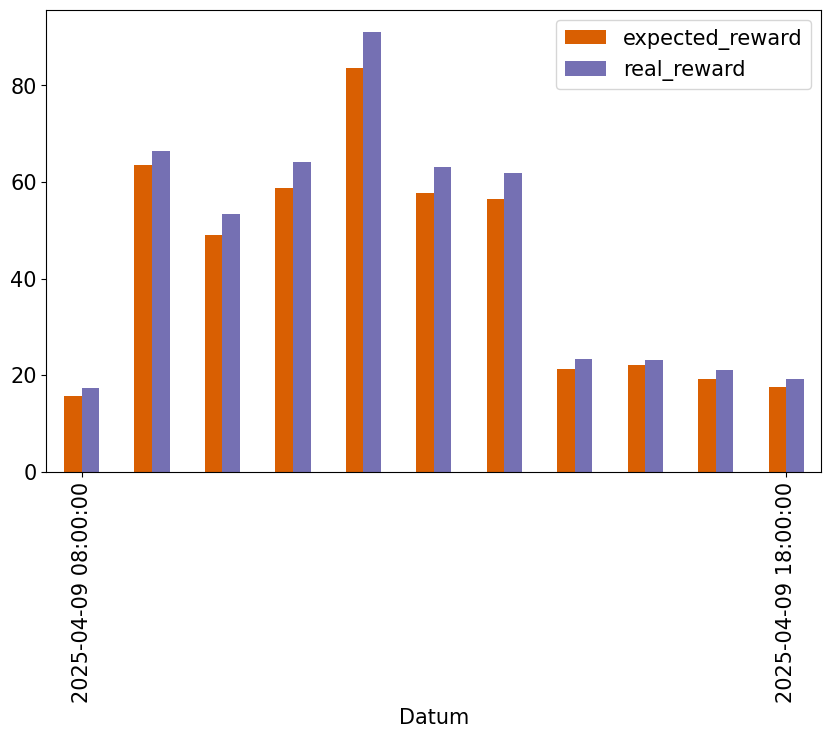

In [52]:
df_exp_real = dvpps_infos[service].groupby(level=0)[['expected_reward', 'real_reward']].mean()
# df_exp_real['diff'] = df_exp_real['real_reward'] - df_exp_real['expected_reward']
df_exp_real.plot.bar(figsize=(10,6))
# set x axis labels as only start and end time and 5 time points in between
plt.xticks([0, len(df_exp_real)-1], [df_exp_real.index[0], df_exp_real.index[-1]])
plt.show()

### Analyze some individual games

In [ ]:
from src.get_optimal_bid import get_optimal_bid
import numpy as np

In [ ]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")
# Extract the first 4 colors
base_colors = [cmap(i) for i in range(10)]
# Create extended cycle: first full alpha, then alpha=0.5
# colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]
# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

C:\Users\pasca\AppData\Local\Temp\ipykernel_20852\216728504.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


In [ ]:
# load bids dataframe
df_bids = pd.read_csv(f'{main_path}/bids_DPF_{service}.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')

In [ ]:
def map_idx_to_datetime(idx):
    vals = dvpps_infos[service].index.get_level_values(0).unique().values
    return pd.Timestamp(vals[idx])
def map_datetime_to_idx(dt):
    vals = dvpps_infos[service].index.get_level_values(0).unique().values
    for i, v in enumerate(vals):
        if v == dt:
            return i
    return None

In [ ]:
dict_idxs = {}
dict_realized_type_game = {}
for type_game in GAME_types_to_plot:
    dict_idxs[type_game] = df_rewards[df_rewards['Method']==type_game].index.get_level_values(0).unique()
    dict_realized_type_game[type_game] = df_rewards.loc[(dict_idxs[type_game], 'Realized-Reward'), 'Method-Realized'].values
    dict_idxs[type_game] = np.array([map_idx_to_datetime(i) for i in dict_idxs[type_game]])

In [ ]:
def bid_value(bids, rho, bid,
              return_prob=False):
    gamma = sum(rho for b in bids if b >= bid)
    if return_prob:
        return gamma
    return bid * (4 * gamma - 3)

In [ ]:
def bids_to_values(bids, rho, return_prob=False) -> np.ndarray:
    values = np.array([bid_value(bids, rho, b, return_prob=False) for b in bids])
    if not return_prob:
        return values
    else:
        gammas = np.array([bid_value(bids, rho, b, return_prob=True) for b in bids])
        return gammas, values

In [ ]:
cols = df_bids.columns
idx_tuples = [eval(col) for col in df_bids.columns.values]
idx_frozensets = [frozenset(tup) for tup in idx_tuples]
the_map = {fs: col for fs, col in zip(idx_frozensets, cols)}

In [ ]:
MAP_METHOD_TO_TYPE = {'Shapley': 'Convex', 'Nucleolus': 'Supperadditive/Non-Empty Core', 'Sub-Game': 'Empty Core'}

## individual times plotting

Bids are invalid (max bid: 0.415, mean bid: -0.146), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-08 07:00:00, optimal partition is [frozenset({'Wind', 'BESS', 'PV'})] with value 6.53912.
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 3.270, value: 3.270
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 3.270, value: 3.270
Forecasted Game Values:
(PV,)               2.33965
(Wind,)             0.00000
(BESS,)             0.00000
(PV, Wind)          2.47159
(PV, BESS)          5.88727
(Wind, BESS)        0.00000
(PV, Wind, BESS)    6.53912
Name: (FFR-FCR, 55), dtype: float64
Realized Game Values:
(PV,)               3.59848
(Wind,)             0.00000
(BESS,)             0.00000
(PV, Wind)          2.59870
(PV, BESS)          6.23059
(Wind, BESS)        0.00000
(PV, Wind, BESS)    6.79334
Name: (FFR-FCR, 55), dtype: float64
Forecasted and Real

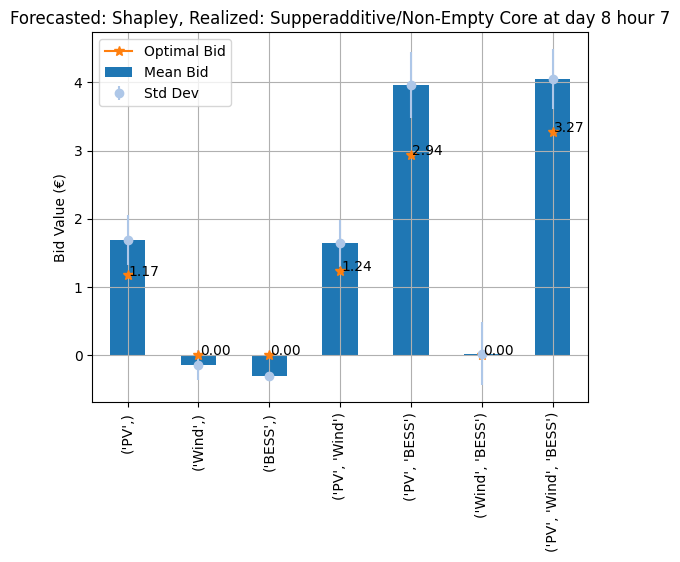

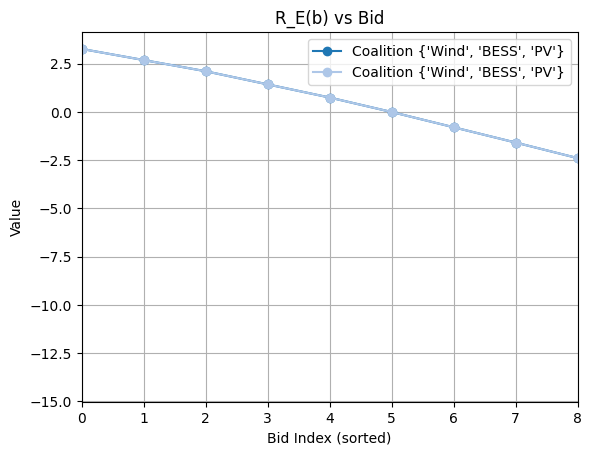

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-10 01:00:00, optimal partition is [frozenset({'Wind', 'BESS', 'PV'})] with value 5.36909.
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 7.159, value: 7.159
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 7.159, value: 7.159
Forecasted Game Values:
(PV,)               0.00000
(Wind,)             3.86686
(BESS,)             0.00000
(PV, Wind)          3.86686
(PV, BESS)          0.00000
(Wind, BESS)        5.36909
(PV, Wind, BESS)    5.36909
Name: (FFR-FCR, 97), dtype: float64
Realized Game Values:
(PV,)               0.00000
(Wind,)             4.86835
(BESS,)             0.00000
(PV, Wind)          4.86835
(PV, BESS)          0.00000
(Wind, BESS)      

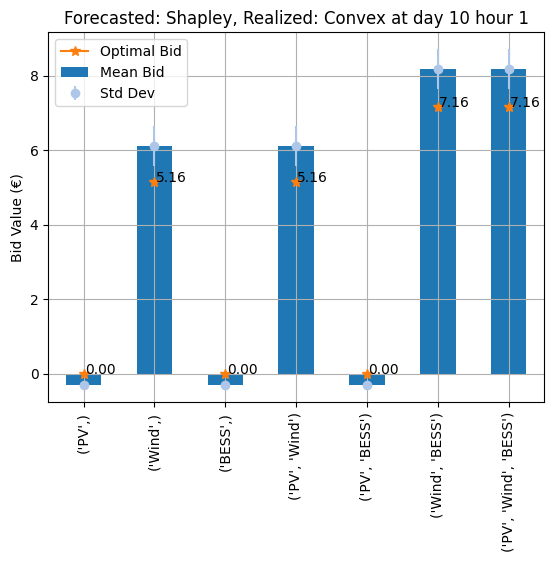

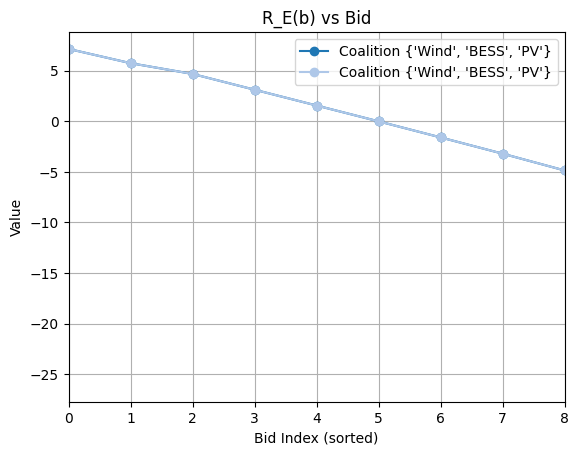

Bids are invalid (max bid: 0.384, mean bid: -0.144), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-06 04:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 0.86247.
Coalition frozenset({'Wind'}) max value at index 10, bid: -0.221, value: 0.221
Coalition frozenset({'BESS', 'PV'}) max value at index 4, bid: 0.127, value: 0.025
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 2, bid: 0.207, value: 0.124
Forecasted Game Values:
(PV,)               0.00000
(Wind,)             0.77403
(BESS,)             0.00000
(PV, Wind)          0.00000
(PV, BESS)          0.08844
(Wind, BESS)        0.00000
(PV, Wind, BESS)    0.43396
Name: (FFR-FCR, 4), dtype: float64
Realized Game Values:
(PV,)               0.00000
(Wind,)             0.00000
(BESS,)             0.00000
(PV, Wind)          0.00000
(PV, BESS)          0.44219
(Wind, BESS)        0.00000


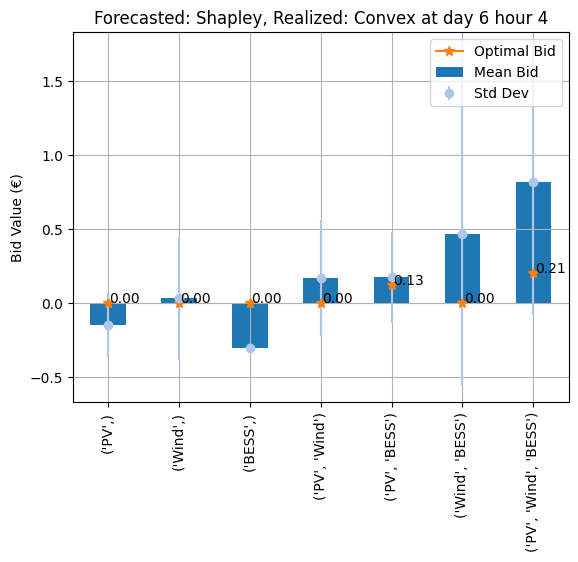

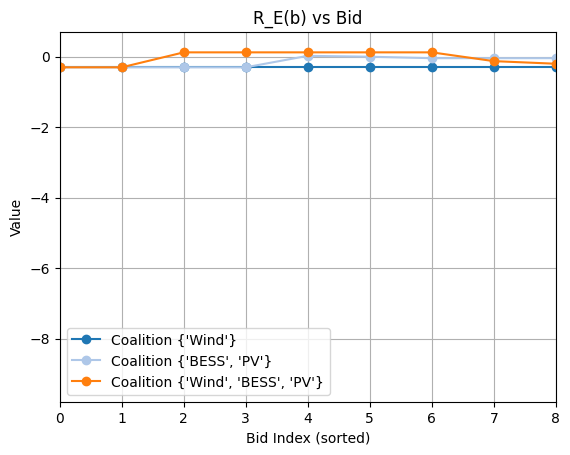

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-08 14:00:00, optimal partition is [frozenset({'Wind', 'BESS', 'PV'})] with value 5.07691.
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 5.077, value: 5.077
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 5.077, value: 5.077
Forecasted Game Values:
(PV,)               2.62491
(Wind,)             0.00000
(BESS,)             0.00000
(PV, Wind)          2.56941
(PV, BESS)          4.93597
(Wind, BESS)        0.00000
(PV, Wind, BESS)    5.07691
Name: (FFR-FCR, 62), dtype: float64
Realized Game Values:
(PV,)               3.13848
(Wind,)             0.00000
(BESS,)             0.00000
(PV, Wind)          2.84802
(PV, BESS)          5.19276
(Wind, BESS)        0.00000
(PV, Wind, BESS)    5.21622
Name: (FFR-FCR, 62), dtype: float64
Forecasted and Realized rewards:
                        PV     Wind     BESS   Method Method-Realized
Forecas

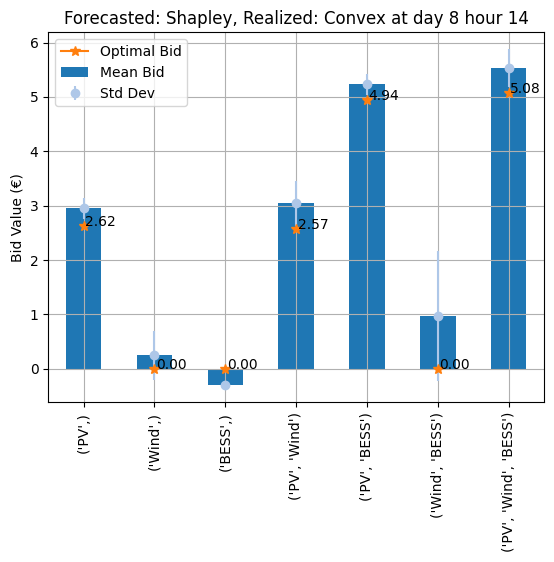

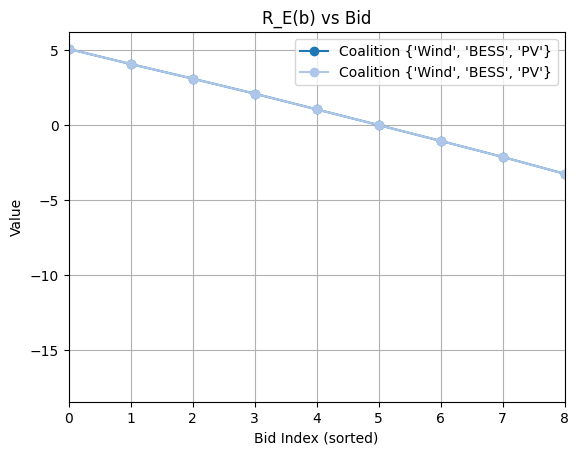

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-08 09:00:00, optimal partition is [frozenset({'Wind', 'BESS', 'PV'})] with value 5.43745.
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 4.350, value: 4.350
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 4.350, value: 4.350
Forecasted Game Values:
(PV,)               2.48693
(Wind,)             0.00000
(BESS,)             0.00000
(PV, Wind)          2.43364
(PV, BESS)          5.40637
(Wind, BESS)        0.02859
(PV, Wind, BESS)    5.43745
Name: (FFR-FCR, 57), dtype: float64
Realized Game Values:
(PV,)               3.33843
(Wind,)             0.00000
(BESS,)             0.00000
(PV, Wind)          2.55880
(PV, BESS)          5.64966
(Wind, BESS)       -0.42884
(PV, Wind, BESS)    5.68777
Name: (FFR-FCR, 57), dtype: float64
Forecasted and Realized rewards:
                         PV      Wind      BESS   Method Method-Realized
Fore

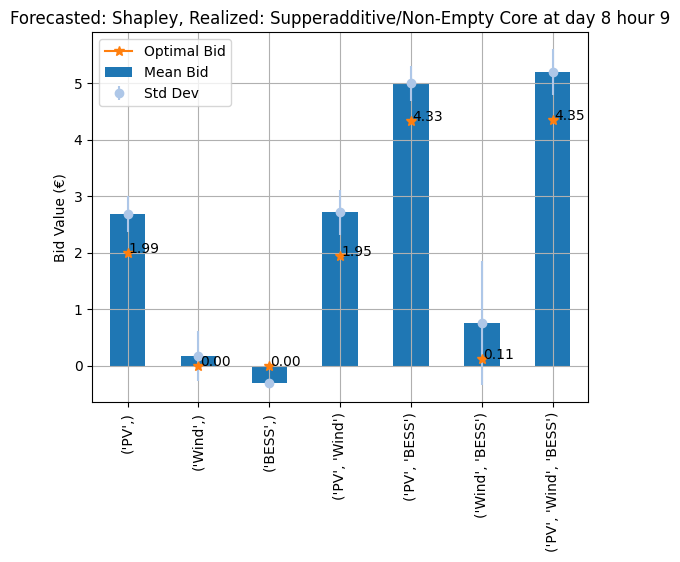

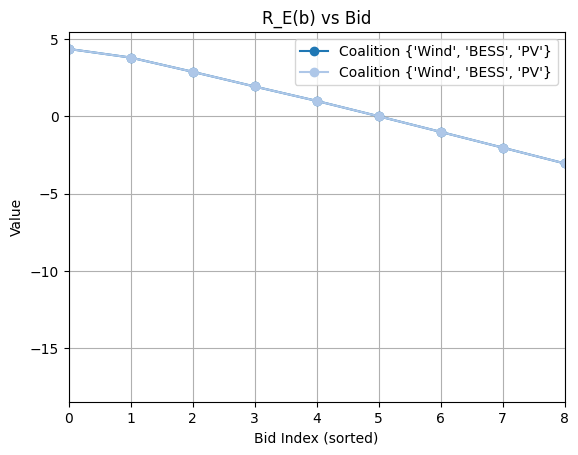

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-10 06:00:00, optimal partition is [frozenset({'Wind', 'BESS', 'PV'})] with value 5.03321.
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 4.027, value: 4.027
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 4.027, value: 4.027
Forecasted Game Values:
(PV,)               1.74013
(Wind,)             0.00000
(BESS,)             0.00000
(PV, Wind)          1.94011
(PV, BESS)          4.37869
(Wind, BESS)        0.00000
(PV, Wind, BESS)    5.03321
Name: (FFR-FCR, 102), dtype: float64
Realized Game Values:
(PV,)               2.59128
(Wind,)             0.00000
(BESS,)             0.00000
(PV, Wind)          2.33922
(PV, BESS)          4.54892
(Wind, BESS)        0.00000
(PV, Wind, BESS)    5.03321
Name: (FFR-FCR, 102), dtype: float64
Forecasted and Realized rewards:
                         PV      Wind      BESS   Method Method-Realized
Fo

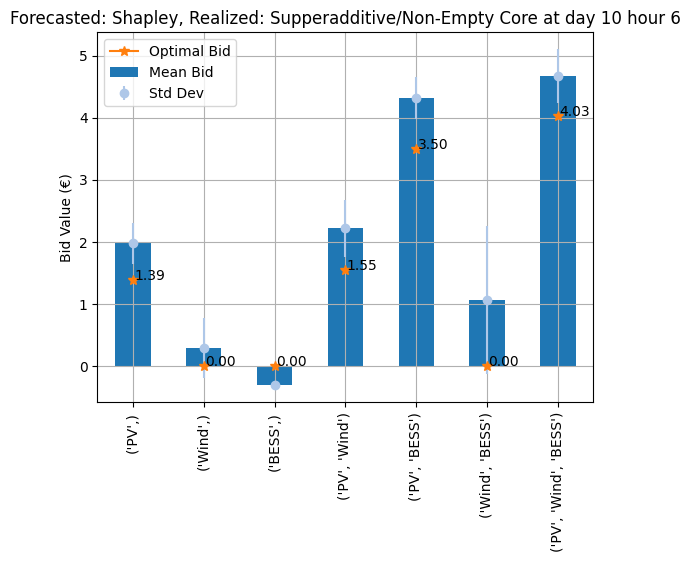

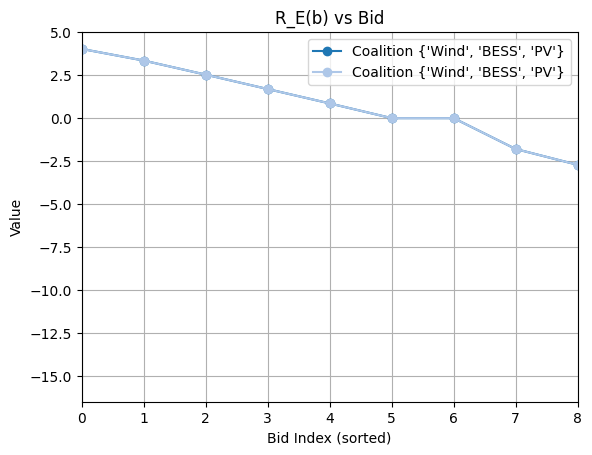

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-07 10:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 49.662490000000005.
Coalition frozenset({'Wind'}) max value at index 10, bid: -0.129, value: 0.129
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 6.079, value: 6.079
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 6.079, value: 6.079
Forecasted Game Values:
(PV,)               30.64475
(Wind,)              1.03061
(BESS,)              0.00000
(PV, Wind)          27.64689
(PV, BESS)          48.63188
(Wind, BESS)         0.00000
(PV, Wind, BESS)    48.63188
Name: (FFR-FCR, 34), dtype: float64
Realized Game Values:
(PV,)               35.14153
(Wind,)              0.00000
(BESS,)              0.00000
(PV, Wind)          30.64475
(PV, BESS)          51.62973
(Wind, BESS)         0.00000
(PV, Wind, BESS)    50.13081
Name: (FFR-FCR, 34), dtype: float64
F

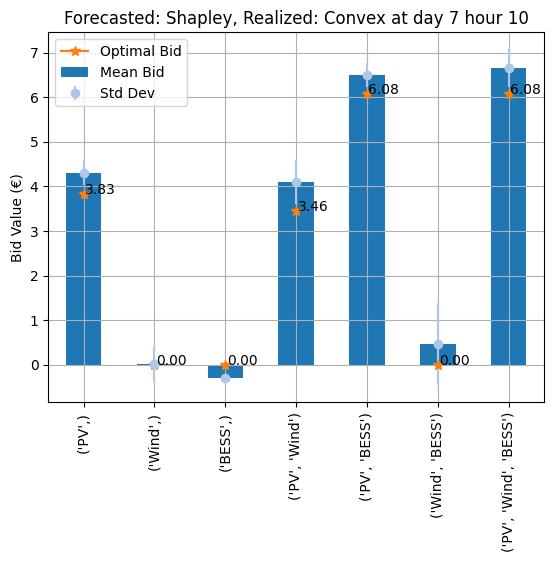

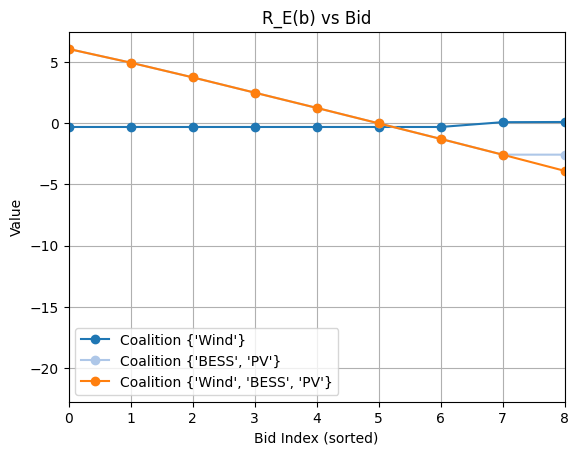

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-06 14:00:00, optimal partition is [frozenset({'Wind', 'BESS', 'PV'})] with value 99.12477.
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 3.937, value: 3.937
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 3.937, value: 3.937
Forecasted Game Values:
(PV,)               35.56780
(Wind,)              0.89443
(BESS,)              0.00000
(PV, Wind)          36.24386
(PV, BESS)          89.49941
(Wind, BESS)         0.00000
(PV, Wind, BESS)    99.12477
Name: (FFR-FCR, 14), dtype: float64
Realized Game Values:
(PV,)                44.26645
(Wind,)               0.00000
(BESS,)               0.00000
(PV, Wind)           42.13894
(PV, BESS)           92.97887
(Wind, BESS)          0.00000
(PV, Wind, BESS)    101.08980
Name: (FFR-FCR, 14), dtype: float64
Forecasted and Realized rewards:
                          PV      Wind       BESS   Met

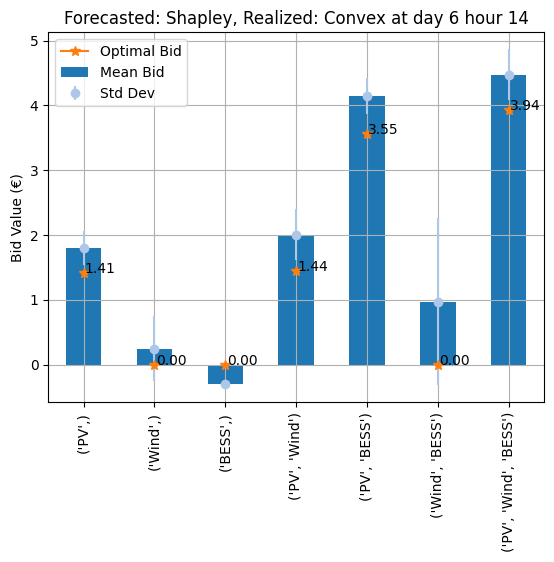

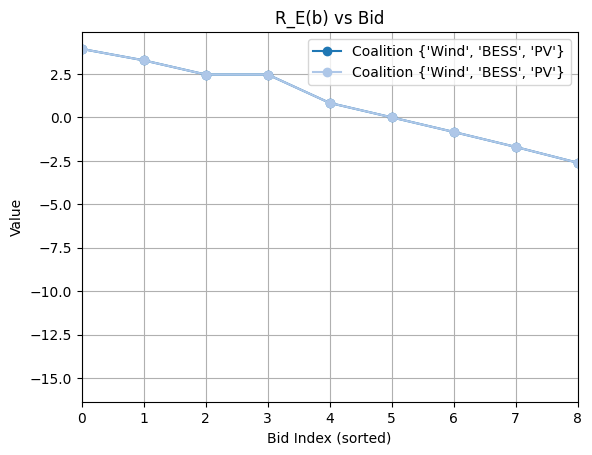

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-06 11:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 140.34213000000003.
Coalition frozenset({'Wind'}) max value at index 8, bid: -0.129, value: 0.077
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 5.437, value: 5.437
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 5.509, value: 5.509
Forecasted Game Values:
(PV,)                82.13223
(Wind,)               1.96718
(BESS,)               0.00000
(PV, Wind)           75.08352
(PV, BESS)          138.37495
(Wind, BESS)          1.64325
(PV, Wind, BESS)    140.21621
Name: (FFR-FCR, 11), dtype: float64
Realized Game Values:
(PV,)                98.20157
(Wind,)               0.00000
(BESS,)               0.00000
(PV, Wind)           83.22510
(PV, BESS)          146.40962
(Wind, BESS)          0.00000
(PV, Wind, BESS)    148.35779
Name: (FFR-FCR, 11), dty

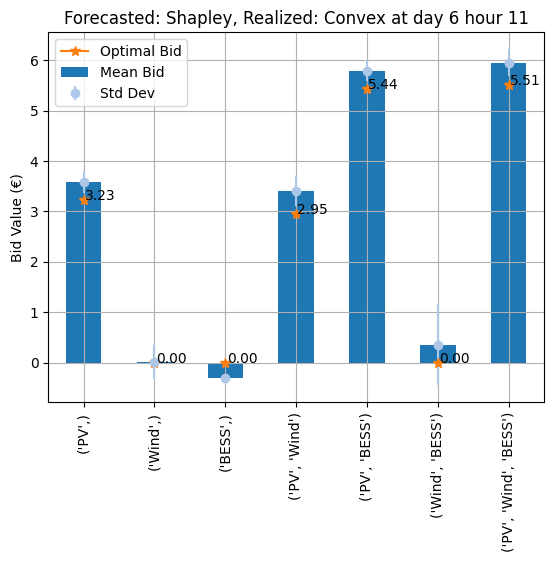

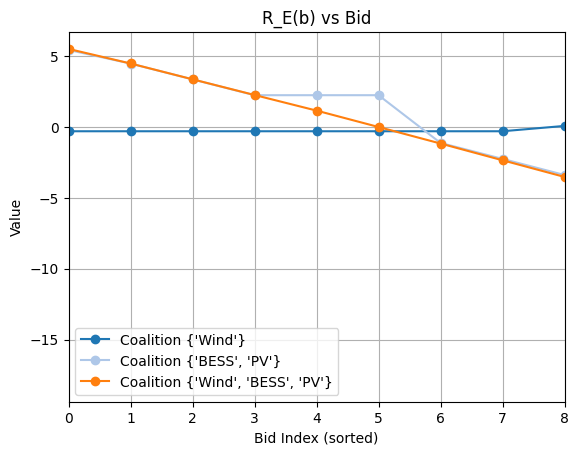

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-08 11:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 27.94651.
Coalition frozenset({'Wind'}) max value at index 10, bid: -0.129, value: 0.129
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 4.529, value: 4.529
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 4.529, value: 4.529
Forecasted Game Values:
(PV,)               13.08883
(Wind,)              0.77296
(BESS,)              0.00000
(PV, Wind)          12.28879
(PV, BESS)          27.17355
(Wind, BESS)         0.76653
(PV, Wind, BESS)    27.17355
Name: (FFR-FCR, 59), dtype: float64
Realized Game Values:
(PV,)               16.28990
(Wind,)              0.00000
(BESS,)              0.00000
(PV, Wind)          13.62131
(PV, BESS)          28.45398
(Wind, BESS)         0.00000
(PV, Wind, BESS)    27.81377
Name: (FFR-FCR, 59), dtype: float64
Forecasted 

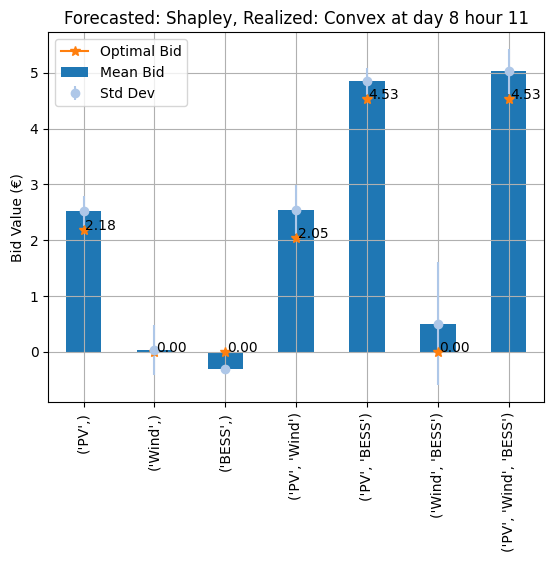

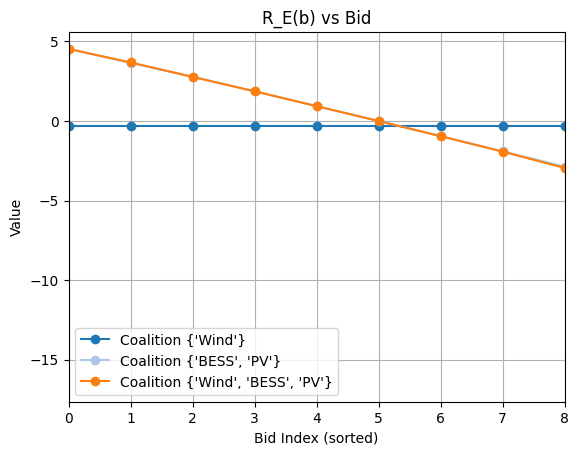

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-09 08:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 17.04785.
Coalition frozenset({'Wind'}) max value at index 0, bid: 5.374, value: 5.374
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 4.368, value: 4.368
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 9.427, value: 9.427
Forecasted Game Values:
(PV,)                3.51593
(Wind,)              9.40453
(BESS,)              0.00000
(PV, Wind)          13.26955
(PV, BESS)           7.64332
(Wind, BESS)        13.05809
(PV, Wind, BESS)    16.49728
Name: (FFR-FCR, 80), dtype: float64
Realized Game Values:
(PV,)                6.09555
(Wind,)              9.40453
(BESS,)              0.00000
(PV, Wind)          14.88341
(PV, BESS)           7.98727
(Wind, BESS)        13.05809
(PV, Wind, BESS)    18.11114
Name: (FFR-FCR, 80), dtype: float64
Forecasted an

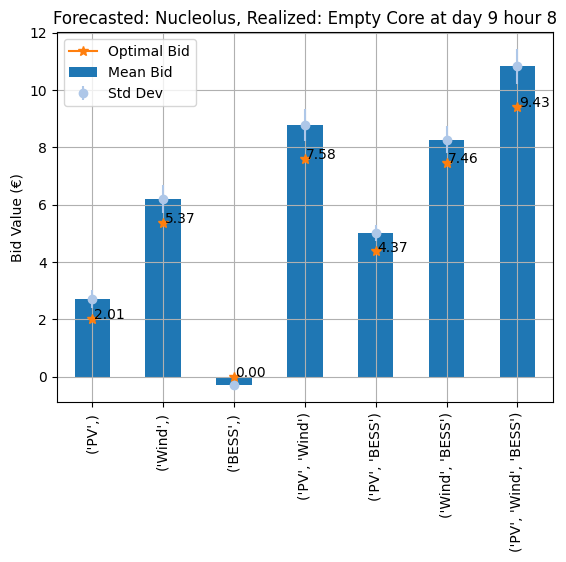

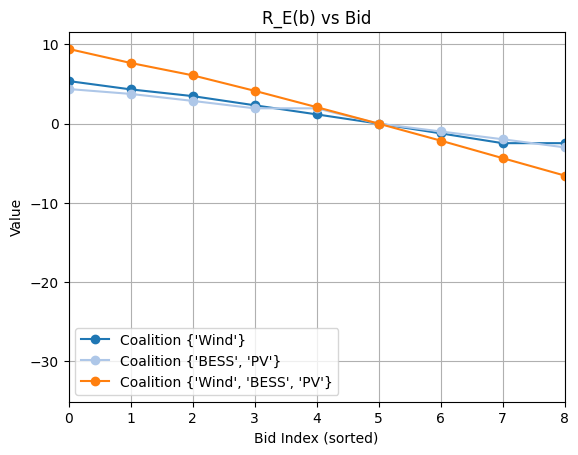

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-12 08:00:00, optimal partition is [frozenset({'Wind', 'BESS', 'PV'})] with value 216.6917.
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 7.625, value: 7.625
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 7.625, value: 7.625
Forecasted Game Values:
(PV,)                 0.00000
(Wind,)             156.06293
(BESS,)               0.00000
(PV, Wind)          156.06293
(PV, BESS)            4.84100
(Wind, BESS)        216.69170
(PV, Wind, BESS)    216.69170
Name: (FFR-FCR, 152), dtype: float64
Realized Game Values:
(PV,)                 0.00000
(Wind,)             176.27252
(BESS,)               0.00000
(PV, Wind)          176.27252
(PV, BESS)            0.00000
(Wind, BESS)        226.79649
(PV, Wind, BESS)    226.79649
Name: (FFR-FCR, 152), dtype: float64
Forecasted and Realized rewards:
                    PV        Wind       BESS 

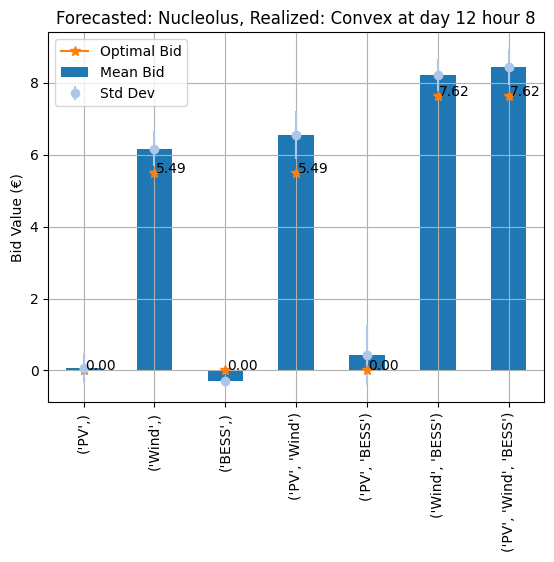

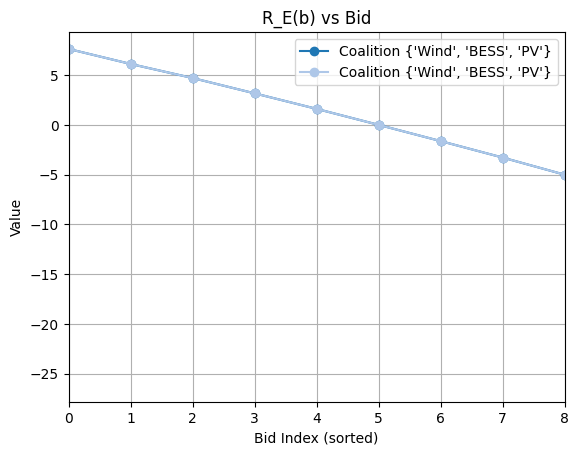

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-11 05:00:00, optimal partition is [frozenset({'Wind', 'BESS', 'PV'})] with value 6.93529.
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 6.935, value: 6.935
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 6.935, value: 6.935
Forecasted Game Values:
(PV,)               0.10823
(Wind,)             4.29545
(BESS,)             0.00000
(PV, Wind)          4.86457
(PV, BESS)          0.25965
(Wind, BESS)        6.49343
(PV, Wind, BESS)    6.93529
Name: (FFR-FCR, 125), dtype: float64
Realized Game Values:
(PV,)              -0.81176
(Wind,)             6.41227
(BESS,)             0.00000
(PV, Wind)          6.34366
(PV, BESS)          0.68698
(Wind, BESS)        7.04737
(PV, Wind, BESS)    7.52693
Name: (FFR-FCR, 125), dtype: float64
Forecasted and Realized rewards:
                         PV      Wind      BESS     Method Method-Realized


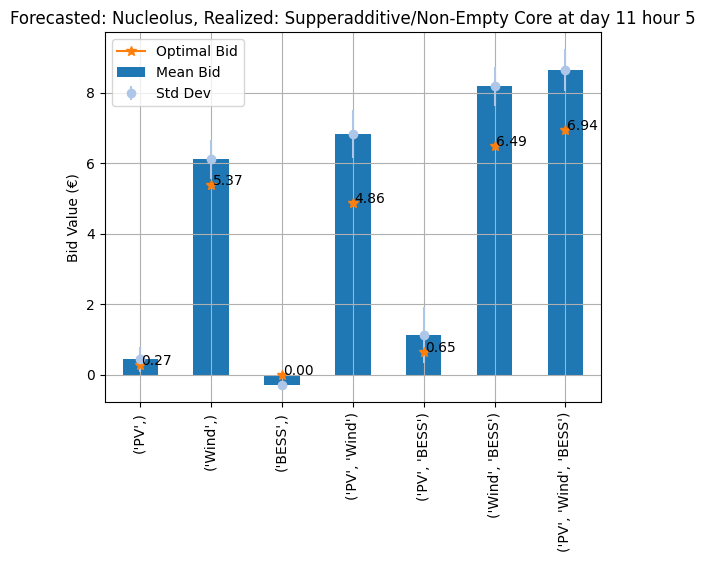

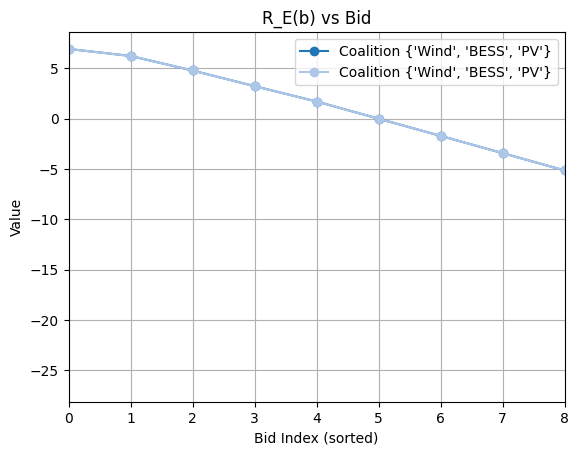

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-12 14:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 297.84198.
Coalition frozenset({'Wind'}) max value at index 0, bid: 5.816, value: 5.816
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 5.045, value: 5.045
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 10.858, value: 10.858
Forecasted Game Values:
(PV,)                75.53646
(Wind,)             159.49531
(BESS,)               0.00000
(PV, Wind)          239.52276
(PV, BESS)          138.34667
(Wind, BESS)        214.64673
(PV, Wind, BESS)    297.78505
Name: (FFR-FCR, 158), dtype: float64
Realized Game Values:
(PV,)                90.31533
(Wind,)             169.82235
(BESS,)               0.00000
(PV, Wind)          254.08833
(PV, BESS)          145.73610
(Wind, BESS)        225.14575
(PV, Wind, BESS)    312.35062
Name: (FFR-FCR, 158), dtype: fl

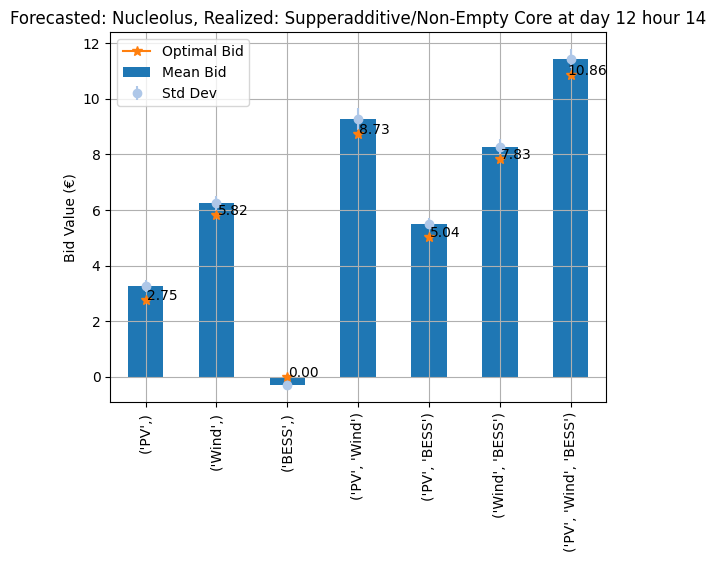

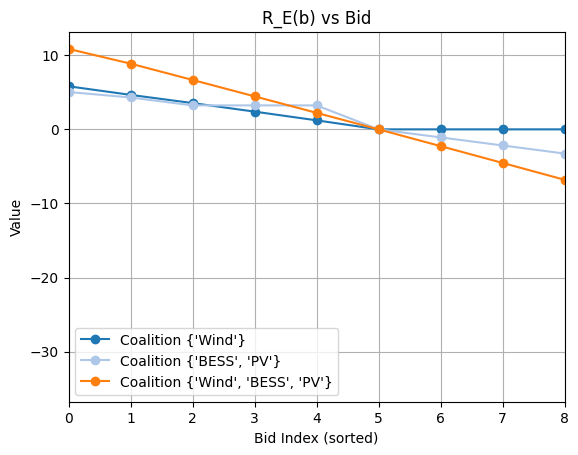

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-09 12:00:00, optimal partition is [frozenset({'Wind', 'BESS', 'PV'})] with value 87.12345.
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 8.721, value: 8.721
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 8.721, value: 8.721
Forecasted Game Values:
(PV,)               20.05936
(Wind,)             43.10479
(BESS,)              0.00000
(PV, Wind)          66.80969
(PV, BESS)          43.60729
(Wind, BESS)        65.43245
(PV, Wind, BESS)    87.12345
Name: (FFR-FCR, 84), dtype: float64
Realized Game Values:
(PV,)               20.05936
(Wind,)             62.64149
(BESS,)              0.00000
(PV, Wind)          78.99795
(PV, BESS)          43.60729
(Wind, BESS)        71.01436
(PV, Wind, BESS)    95.24895
Name: (FFR-FCR, 84), dtype: float64
Forecasted and Realized rewards:
                          PV       Wind       BESS     Method 

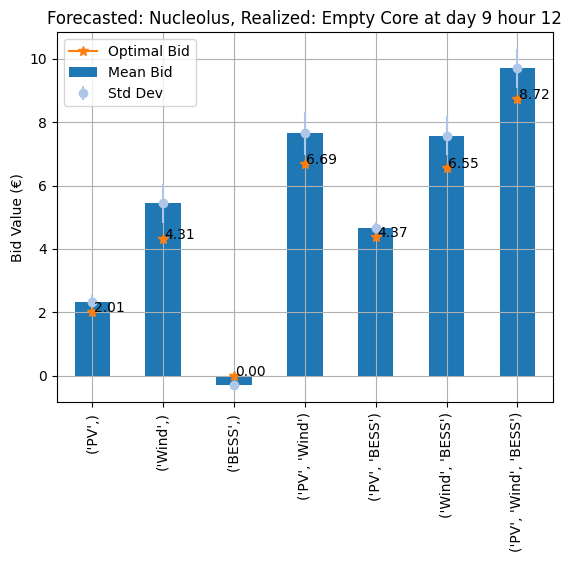

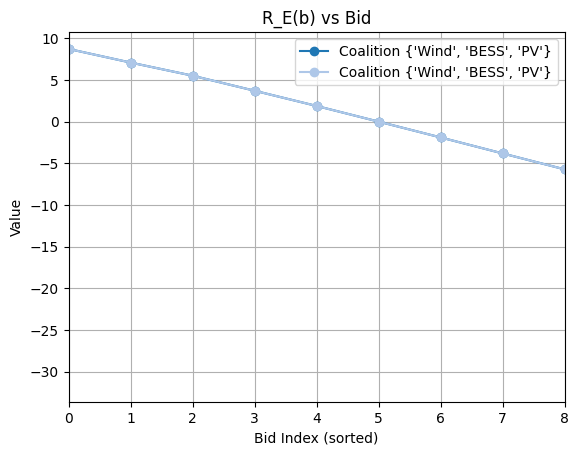

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-12 17:00:00, optimal partition is [frozenset({'Wind', 'BESS', 'PV'})] with value 76.29902.
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 8.525, value: 8.525
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 8.525, value: 8.525
Forecasted Game Values:
(PV,)                7.31670
(Wind,)             47.79214
(BESS,)              0.00000
(PV, Wind)          58.74242
(PV, BESS)          18.41103
(Wind, BESS)        66.35888
(PV, Wind, BESS)    76.29902
Name: (FFR-FCR, 161), dtype: float64
Realized Game Values:
(PV,)              -21.95009
(Wind,)             57.07551
(BESS,)              0.00000
(PV, Wind)          62.31460
(PV, BESS)         -55.23310
(Wind, BESS)        72.54779
(PV, Wind, BESS)    80.03103
Name: (FFR-FCR, 161), dtype: float64
Forecasted and Realized rewards:
                         PV       Wind       BESS     Method

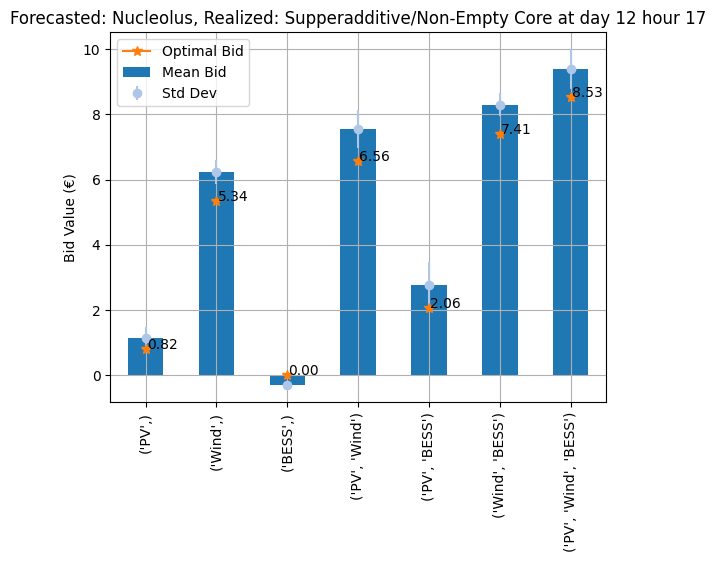

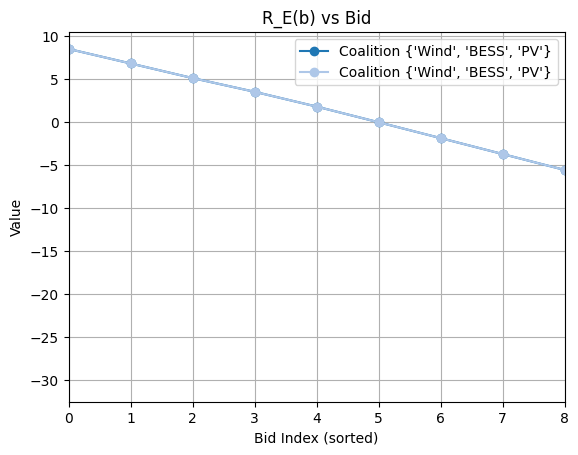

Bids are invalid (max bid: 0.423, mean bid: -0.131), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-10 04:00:00, optimal partition is [frozenset({'Wind', 'BESS', 'PV'})] with value 1.62532.
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 1, bid: 3.728, value: 2.982
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 1, bid: 3.728, value: 2.982
Forecasted Game Values:
(PV,)               0.00000
(Wind,)             0.56958
(BESS,)             0.00000
(PV, Wind)          0.59046
(PV, BESS)          0.09427
(Wind, BESS)        1.60866
(PV, Wind, BESS)    1.62532
Name: (FFR-FCR, 100), dtype: float64
Realized Game Values:
(PV,)               0.00000
(Wind,)             1.05833
(BESS,)             0.00000
(PV, Wind)          1.09713
(PV, BESS)          0.00000
(Wind, BESS)        2.09742
(PV, Wind, BESS)    2.17194
Name: (FFR-FCR, 100), dtype: float64
Forecasted and Re

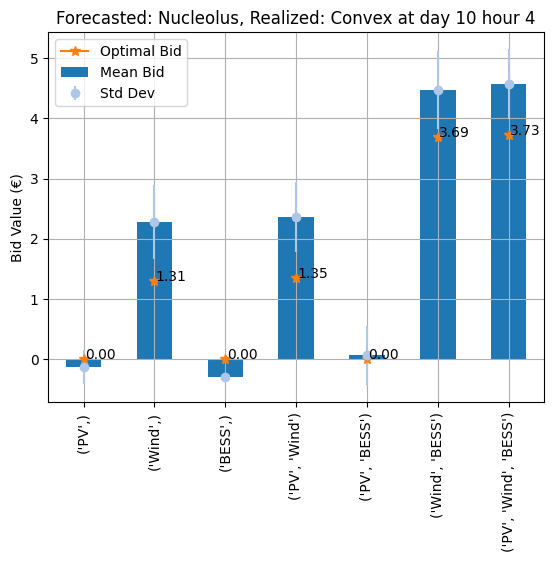

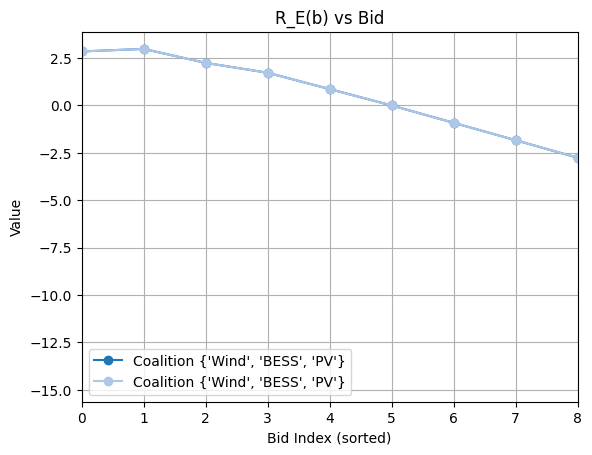

Bids are invalid (max bid: 0.184, mean bid: -0.106), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-09 20:00:00, optimal partition is [frozenset({'Wind', 'BESS', 'PV'})] with value 22.96341.
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 7.654, value: 7.654
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 7.654, value: 7.654
Forecasted Game Values:
(PV,)                0.00000
(Wind,)             16.41539
(BESS,)              0.00000
(PV, Wind)          17.60925
(PV, BESS)           0.39032
(Wind, BESS)        22.79259
(PV, Wind, BESS)    22.96341
Name: (FFR-FCR, 92), dtype: float64
Realized Game Values:
(PV,)                0.00000
(Wind,)             18.54113
(BESS,)              0.00000
(PV, Wind)          18.68008
(PV, BESS)           0.00000
(Wind, BESS)        24.91833
(PV, Wind, BESS)    24.03425
Name: (FFR-FCR, 92), dtype: float64
Fore

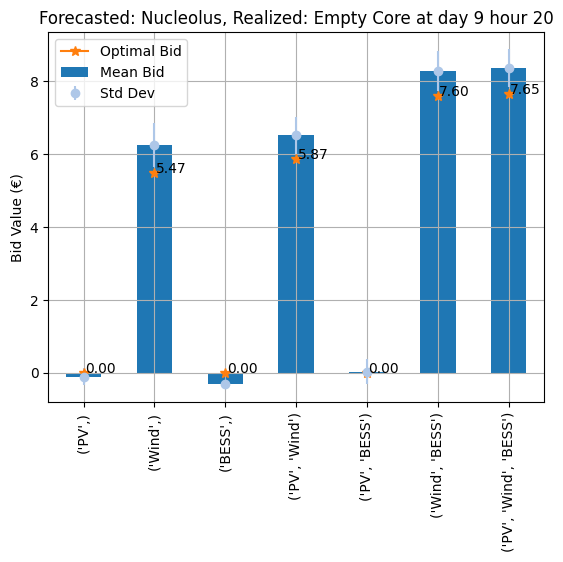

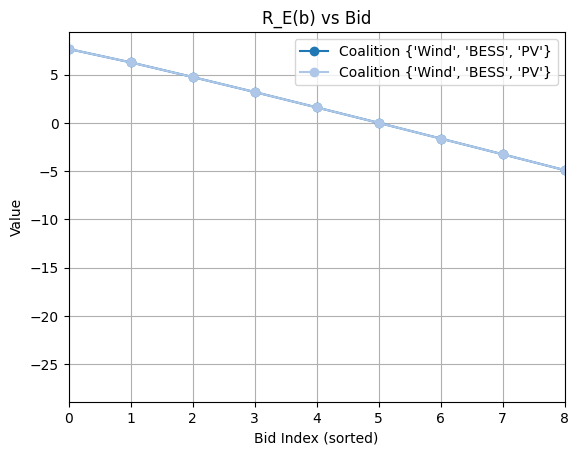

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-11 07:00:00, optimal partition is [frozenset({'Wind', 'BESS', 'PV'})] with value 5.94292.
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 7.429, value: 7.429
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 7.429, value: 7.429
Forecasted Game Values:
(PV,)               0.00000
(Wind,)             4.14571
(BESS,)             0.00000
(PV, Wind)          4.53235
(PV, BESS)          0.03636
(Wind, BESS)        5.75627
(PV, Wind, BESS)    5.94292
Name: (FFR-FCR, 127), dtype: float64
Realized Game Values:
(PV,)               0.00000
(Wind,)             4.95099
(BESS,)             0.00000
(PV, Wind)          5.11927
(PV, BESS)          0.09090
(Wind, BESS)        6.29313
(PV, Wind, BESS)    6.49718
Name: (FFR-FCR, 127), dtype: float64
Forecasted and Realized rewards:
                         PV     Wind      BESS     Method Method-Realized
F

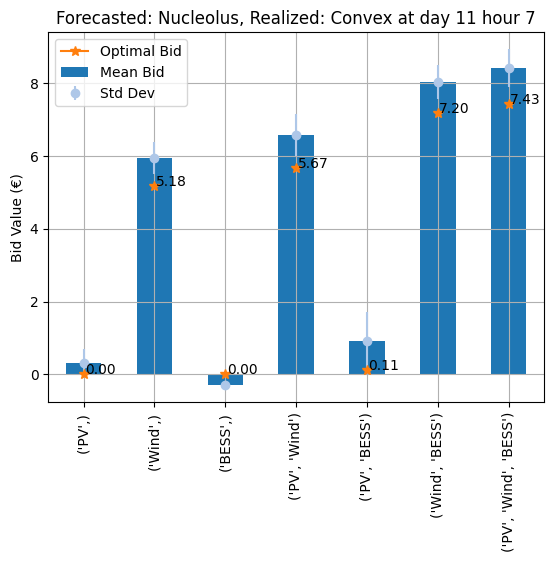

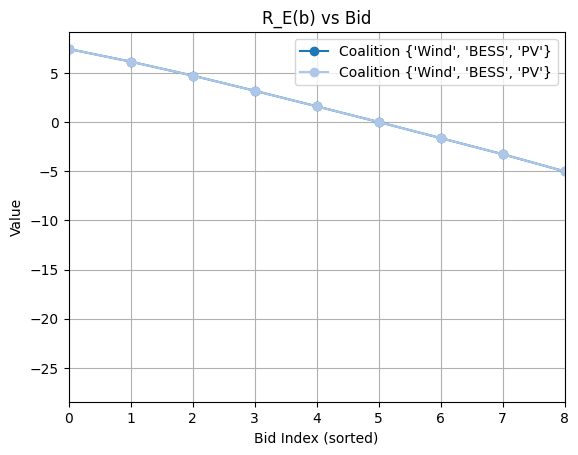

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-09 14:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 56.08537.
Coalition frozenset({'Wind'}) max value at index 0, bid: 4.239, value: 4.239
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 4.735, value: 4.735
Coalition frozenset({'Wind', 'BESS', 'PV'}) max value at index 0, bid: 8.900, value: 8.900
Forecasted Game Values:
(PV,)               15.16710
(Wind,)             26.49406
(BESS,)              0.00000
(PV, Wind)          40.75638
(PV, BESS)          29.59131
(Wind, BESS)        40.21760
(PV, Wind, BESS)    55.62695
Name: (FFR-FCR, 86), dtype: float64
Realized Game Values:
(PV,)               15.90897
(Wind,)             40.21760
(BESS,)              0.00000
(PV, Wind)          53.14852
(PV, BESS)          30.34151
(Wind, BESS)        43.64848
(PV, Wind, BESS)    58.10538
Name: (FFR-FCR, 86), dtype: float64
Forecasted an

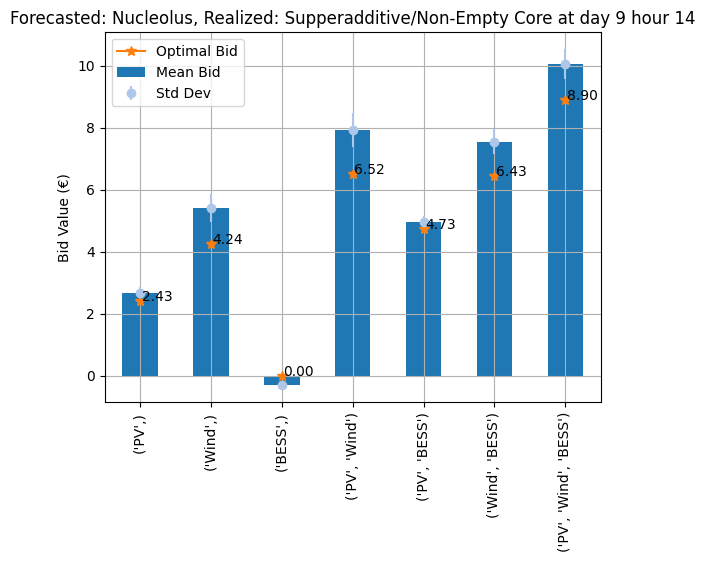

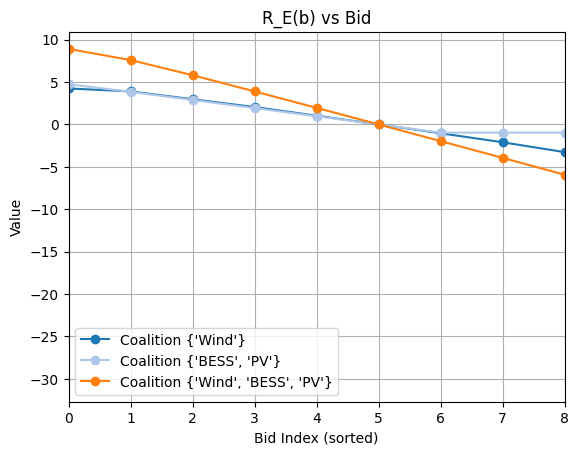

In [ ]:
MAX_GAMES_TO_PLOT = 10  # max games per type to plot

for type_game in GAME_types_to_plot:
    if len(dict_idxs[type_game]) == 0:
        continue
    elif len(dict_idxs[type_game]) < MAX_GAMES_TO_PLOT:
        MAX_GAMES_TO_PLOT = len(dict_idxs[type_game])
    
    # pick 5 random indexes
    np.random.seed(42)
    these_idxs = np.random.choice(len(dict_idxs[type_game]), size=MAX_GAMES_TO_PLOT, replace=False)

    dt_idxs = dict_idxs[type_game][these_idxs]
    realized_methods = dict_realized_type_game[type_game][these_idxs]

    K_errors = len(df_bids.loc[dt_idxs[0]])
    probs = [1/K_errors for _ in range(K_errors)]
    for j, dt in enumerate(dt_idxs):
        # print(dvpps_infos[service].loc[dt])
        # visualize mean and std of each column
        plt.figure()
        plt.title(f'Forecasted: {type_game}, Realized: {MAP_METHOD_TO_TYPE[realized_methods[j]]} at day {dt.day} hour {dt.hour}')
        df_bids.loc[dt].mean(axis=0).plot(kind='bar', label='Mean Bid')
        # plot min max with error bars
        plt.errorbar(x=df_bids.loc[dt].columns, y=df_bids.loc[dt].mean(axis=0), yerr=df_bids.loc[dt].std(axis=0), fmt='o', label='Std Dev',
                    color=base_colors[1])
        # compute optimal bid for each coalition and plot as star marker
        dict_opt_bids = {}
        for coalition in df_bids.loc[dt].columns:
            c_bids = np.squeeze(df_bids.loc[dt, [coalition]].values)
            b_star_coalition, value_wo_price, gamma = get_optimal_bid(c_bids, probs, return_reward=True)
            dict_opt_bids[coalition] = b_star_coalition
            # plot as star marker
            plt.plot(coalition, b_star_coalition, marker='*', markersize=7, label='Optimal Bid' if coalition==df_bids.loc[dt].columns[0] else "", color=base_colors[2])
            # annotate value of optimal bid to the right of the star
            plt.annotate(f'{b_star_coalition:.2f}', (coalition, b_star_coalition), textcoords="offset points", xytext=(12, 0), ha='center', fontsize=10)
        plt.ylabel('Bid Value (€)')
        plt.grid()
        plt.legend()

        # next, also plot th eindividual bids in line chart for non-superadditiv coalitions
        idx_numeric = map_datetime_to_idx(dt)
        v = {frozenset(k): val for k, val in df_expected.loc[(service, idx_numeric)].items()}
        v[frozenset()] = 0.0  # ensure empty set has value 0
        max_value, coalitions = solve_optimal_partition(v)
        print(f'At hour {dt}, optimal partition is {coalitions} with value {max_value}.')
        # plot line chart for this coalition
        plt.figure()
        x_ks = np.arange(K_errors)
        # add grand coalition
        coalitions.append(frozenset(players))

        for coalition in coalitions:
            # convert to columns
            col = the_map[coalition]
            the_bids = df_bids.loc[dt, col].values.tolist()
            the_bids.sort()
            # the_bids = the_bids[::-1]
            # convert bids to values
            vals = bids_to_values(the_bids, probs[0])
            # indicate dict_opt_bids in plot
            plt.plot(x_ks, vals, marker='o', label=f'Coalition {set(coalition)}')
            # print idx and bid of max value
            max_idx = np.argmax(vals)
            print(f"Coalition {coalition} max value at index {max_idx}, bid: {the_bids[max_idx]:.3f}, value: {vals[max_idx]:.3f}")

        # print forecasted and realized game values and reward splits
        print("Forecasted Game Values:")
        print(df_expected.loc[(service, idx_numeric)])
        print("Realized Game Values:")
        print(df_realized.loc[(service, idx_numeric)])
        print("Forecasted and Realized rewards:")
        print(df_rewards.loc[idx_numeric])

        plt.xlabel('Bid Index (sorted)')
        plt.ylabel('Value')
        plt.title('R_E(b) vs Bid')
        plt.grid(True)
        plt.xlim((0, 8))
        plt.legend()
        plt.show()

## Plot Examples for Convex, Non-Empty Core and Sub-Coaltiions

In [ ]:
v = {}
v[frozenset()] = 0
v[frozenset({'PV'})] = 0.1
v[frozenset({'Wind'})] = 14.9
v[frozenset({'BESS'})] = 0
v[frozenset({'PV', 'Wind'})] = 15
v[frozenset({'PV', 'BESS'})] = 0.1
v[frozenset({'Wind', 'BESS'})] = 22.1
v[frozenset({'PV', 'Wind', 'BESS'})] = 22.2

In [ ]:
# realized game
v = {}
v[frozenset()] = 0
v[frozenset({'PV'})] = 0.1
v[frozenset({'Wind'})] = -44.6
v[frozenset({'BESS'})] = 0
v[frozenset({'PV', 'Wind'})] = -45.1
v[frozenset({'PV', 'BESS'})] = 0.1
v[frozenset({'Wind', 'BESS'})] = -66.3
v[frozenset({'PV', 'Wind', 'BESS'})] = -66.7

In [16]:
# realized game
v = {}
v[frozenset()] = 0
v[frozenset({'PV'})] = 15.9
v[frozenset({'Wind'})] = 40.2
v[frozenset({'BESS'})] = 0
v[frozenset({'PV', 'Wind'})] = 53.1
v[frozenset({'PV', 'BESS'})] = 30.3
v[frozenset({'Wind', 'BESS'})] = 43.6
v[frozenset({'PV', 'Wind', 'BESS'})] = 58.1

In [17]:
v[frozenset({'PV'})] + v[frozenset({'Wind'})]

56.1

In [18]:
v_new = make_game_superadditive(v, ['PV', 'Wind', 'BESS'])

In [19]:
v_new

{frozenset(): 0,
 frozenset({'PV'}): 15.9,
 frozenset({'Wind'}): 40.2,
 frozenset({'BESS'}): 0,
 frozenset({'PV', 'Wind'}): 53.1,
 frozenset({'BESS', 'PV'}): 30.3,
 frozenset({'BESS', 'Wind'}): 43.6,
 frozenset({'BESS', 'PV', 'Wind'}): 70.5}

In [15]:
is_convex_game(v_new, ['PV', 'Wind', 'BESS'], print_warnings=True)

Game is not convex: frozenset({'PV', 'BESS'}), frozenset({'BESS', 'Wind'})


False

In [ ]:
get_shapley_value(v, ['PV', 'Wind', 'BESS'])

{'PV': -0.16666666666666854,
 'Wind': -55.71666666666667,
 'BESS': -10.816666666666666}

In [ ]:
from src.game_theory_helpers import is_convex_game, game_is_superadditive, core_nonempty

In [ ]:
core_nonempty(v, ['PV', 'Wind', 'BESS'])

False